In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from lenet5_compression import LeNet5
from torch_dataset import TorchDataset
from torchsummary import summary
import torch.nn.utils.prune as prune
import pandas as pd
import numpy as np
import os
import time
from matplotlib import pyplot as plt
from tqdm import tqdm
torch.cuda.is_available()

True

In [3]:
def draw_plot(name, fig_li):
    #fig = plt.figure(1)	#identifies the figure 
    plt.plot([i for i in range(len(fig_li))], fig_li)
    plt.xlabel("epoch",fontsize='13')
    plt.ylabel(name,fontsize='13')
    plt.grid()
    plt.savefig(f'{name}.png')
    #plt.clf()
    
def print_size_of_model(model):
    """ Prints the real size of the model """
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')



In [4]:
def encode_label(y):
        enc_y = np.zeros((y.shape[0],50))
        for idx,label in enumerate(y):
            enc_y[idx,label] = 1
        return torch.from_numpy(enc_y)

def evaluate(Y_pred, Y_True):
        # Top-1
        pred_label = np.argmax(Y_pred, axis=1)
        top1 = round(sum(Y_True == pred_label)/(1.0*len(Y_True)), 4)

        # Top-5
        size = Y_True.shape[0]
        count = 0
        for i in range(size):
            top5 = np.argpartition(Y_pred[i],-5)[-5:]
            if Y_True[i] in top5:
                count += 1
        top5 = round(count/size,4)

        return top1,top5

In [5]:
def train(train_data):
    model.train()
    train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=False)

    for train_x, train_y in  tqdm(train_loader):

        optimizer.zero_grad()
        
        N,H,W = train_x.shape
        train_x = train_x.reshape(N,1,H,W)
        train_y = encode_label(train_y)
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        
        predict_y = model(train_x.float())
        
        loss = criterion(train_y.float(), predict_y)
        loss.backward()
        
        optimizer.step()
        
    return loss.item()

def test(test_data_):
    model.eval()
    test_data_ = DataLoader(dataset=test_data_, batch_size=450, shuffle=False)

    for idx, (test_x, test_y) in enumerate(test_data_):
            N,H,W = test_x.shape
            test_x = test_x.reshape(N,1,H,W)
            
            test_x = test_x.to(device)
            test_y = test_y.to(device)
        
            predict_y = model(test_x.float()).cpu()
            predict_y = predict_y.detach().numpy()
            test_y = test_y.cpu()
            test_y = test_y.detach().numpy().reshape(-1)
            
            top1,top5 = evaluate(predict_y, test_y)

    return top1,top5


In [6]:
pre_path = "../image/"
train = 'train.txt'
val = 'val.txt'
test = 'test.txt'

train_data = TorchDataset(filename=os.path.join(pre_path, train), image_dir=pre_path,repeat=1)
val_data = TorchDataset(filename=os.path.join(pre_path, val), image_dir=pre_path,repeat=1)
test_data = TorchDataset(filename=os.path.join(pre_path, test), image_dir=pre_path,repeat=1)


In [7]:
epoch = 1
batch = 200
model = LeNet5()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.cuda()

## quantization

In [7]:
print(model)
print_size_of_model(model)

LeNet5(
  (C1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (Sigmoid1): ReLU()
  (S2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (C3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Sigmoid2): ReLU()
  (S4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (FC5): Linear(in_features=400, out_features=120, bias=True)
  (ReLU3): ReLU()
  (FC6): Linear(in_features=120, out_features=84, bias=True)
  (ReLU4): ReLU()
  (FC7): Linear(in_features=84, out_features=50, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)
Size (MB): 0.263459


In [8]:
model.fuse_model()
print(model)
print_size_of_model(model)

LeNet5(
  (C1): ConvReLU2d(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (Sigmoid1): Identity()
  (S2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (C3): ConvReLU2d(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (Sigmoid2): Identity()
  (S4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (FC5): Linear(in_features=400, out_features=120, bias=True)
  (ReLU3): ReLU()
  (FC6): Linear(in_features=120, out_features=84, bias=True)
  (ReLU4): ReLU()
  (FC7): Linear(in_features=84, out_features=50, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
)
Size (MB): 0.263587


In [8]:
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1            [-1, 1, 32, 32]               0
            Conv2d-2            [-1, 6, 28, 28]             156
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
              ReLU-6           [-1, 16, 10, 10]               0
         MaxPool2d-7             [-1, 16, 5, 5]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 50]           4,250
      DeQuantStub-13                   [-1, 50]               0
Total params: 65,106
Trainable params: 

## pruning

In [10]:
for name, module in model.named_modules():
    # prune 20% of connections in all 2D-conv layers 
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
    # prune 40% of connections in all linear layers 
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.6)

In [ ]:
list(model.C1.weight)

# Train

In [10]:
best_val = best_test = 0
best_val_epoch = best_test_epoch = 0
loss_list = []
train_list = []
val_list = []
test_list = []
start = time.time()
for epoch in range(1):
    loss = train(train_data)
    loss_list.append(loss)
    
    top1_val, top5_val = test(val_data)
    val_list.append(top5_val)
    top1_test, top5_test = test(test_data)
    test_list.append(top5_test)
    if top1_val > best_val:
        best_val = top1_val
        best_val_epoch = epoch
        best_model = model
    if top1_test > best_test:
        best_test = top1_test
        best_test_epoch = epoch
        best_test_model = model
    
    print(loss)
    print(time.time()-start)
end = time.time()
print(end-start)


100%|██████████| 248/248 [02:51<00:00,  1.44it/s]


-45770036.0
173.74872136116028
173.7490315437317


In [15]:
top1_val, top5_val = test(val_data)
print(top1_val, top5_val)

top1_test, top5_test = test(test_data)
print(top1_test, top5_test)



0.02 0.1
0.02 0.1


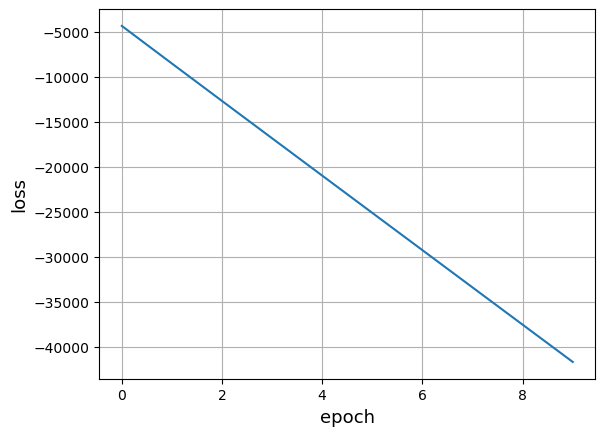

In [10]:
draw_plot("loss", loss_list)